In [10]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from arch import arch_model


In [3]:
#Database Connection
connection = sqlite3.connect(settings.db_name, check_same_thread = False)
repo = SQLRepository(connection=connection)
df_IBM = repo.read_table(table_name="IBM",limit=2500)


In [4]:
def wrangle_data(ticker,n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker,limit=n_observations + 1)


    # Sort DataFrame ascending by date
    df.sort_index(ascending=True,inplace=True)

    # Create "return" column
    df["return"]= df["close"].pct_change() * 100

    # Return returns
    return df["return"].dropna()

In [5]:
y_ibm = wrangle_data(ticker="IBM", n_observations=2500)
y_ibm

date
2013-05-07    0.419173
2013-05-08    0.584393
2013-05-09   -0.771409
2013-05-10    0.605196
2013-05-13   -0.978139
                ...   
2023-04-04   -0.348327
2023-04-05    0.410334
2023-04-06   -1.241108
2023-04-10    0.406130
2023-04-11   -0.465542
Name: return, Length: 2500, dtype: float64

In [8]:
cutoff_test = int(len(y_ibm) * 0.8)
y_IBM_train = y_ibm[:cutoff_test]

print("y_ambuja_train type:", type(y_IBM_train))
print("y_ambuja_train shape:", y_IBM_train.shape)
y_IBM_train.tail()

y_ambuja_train type: <class 'pandas.core.series.Series'>
y_ambuja_train shape: (2000,)


date
2021-04-09    0.451451
2021-04-12   -0.839903
2021-04-13   -2.533621
2021-04-14    1.105351
2021-04-15   -0.037699
Name: return, dtype: float64

In [11]:
# Build and train model
model = arch_model(
    y_IBM_train,
    p=1, #alpha terms -> lag
    q=1, #beta terms
    rescale=False,
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()
# the goal is to make AIC And BIC low as possible 

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3435.60
Distribution:                  Normal   AIC:                           6879.20
Method:            Maximum Likelihood   BIC:                           6901.60
                                        No. Observations:                 2000
Date:                Wed, Apr 12 2023   Df Residuals:                     1999
Time:                        10:37:18   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0114  3.219e-02     -0.355      0.722 [-7.452e-02,5.165e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1861  7.844e-02      2.372  1.767e-02 [3.235e-02,  0.340]
alpha[1]       0.1103  3.985e-02      2.768  5.642e-03 [3.220e-02,  0.188]
beta[1]        0.8023  6.225e-02     12.889  5.183e-38   [  0.680,  0.924]
==========================================================================

Covariance estimator: robust
"""

In [12]:
model.conditional_volatility.tail()

date
2021-04-09    1.267168
2021-04-12    1.223933
2021-04-13    1.209825
2021-04-14    1.436019
2021-04-15    1.406470
Name: cond_vol, dtype: float64

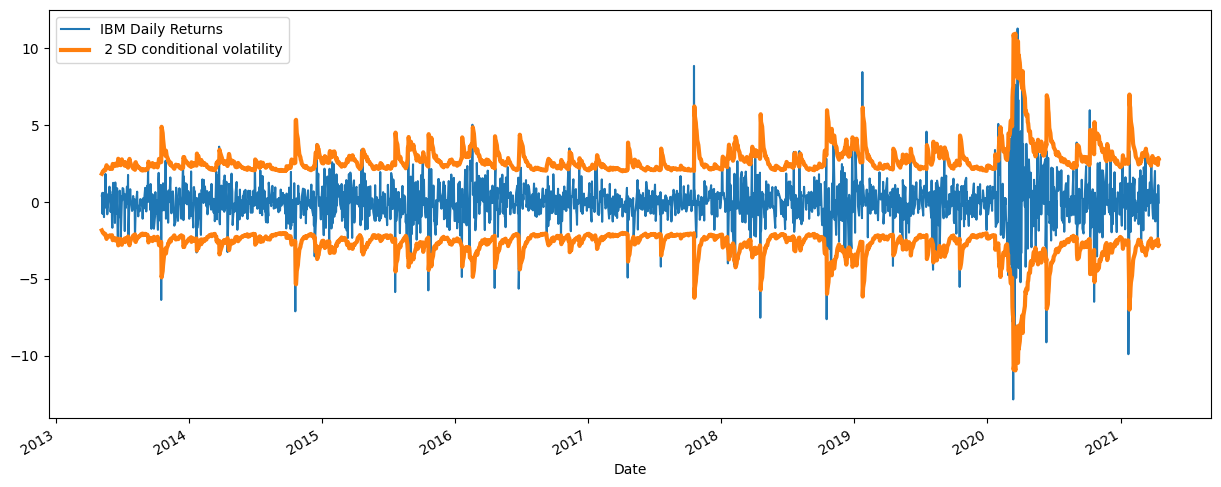

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_IBM_train.plot(ax=ax,label="IBM Daily Returns")

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(ax=ax,color="C1",label=" 2 SD conditional volatility", linewidth=3)

# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(ax=ax,color="C1", linewidth=3)


# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

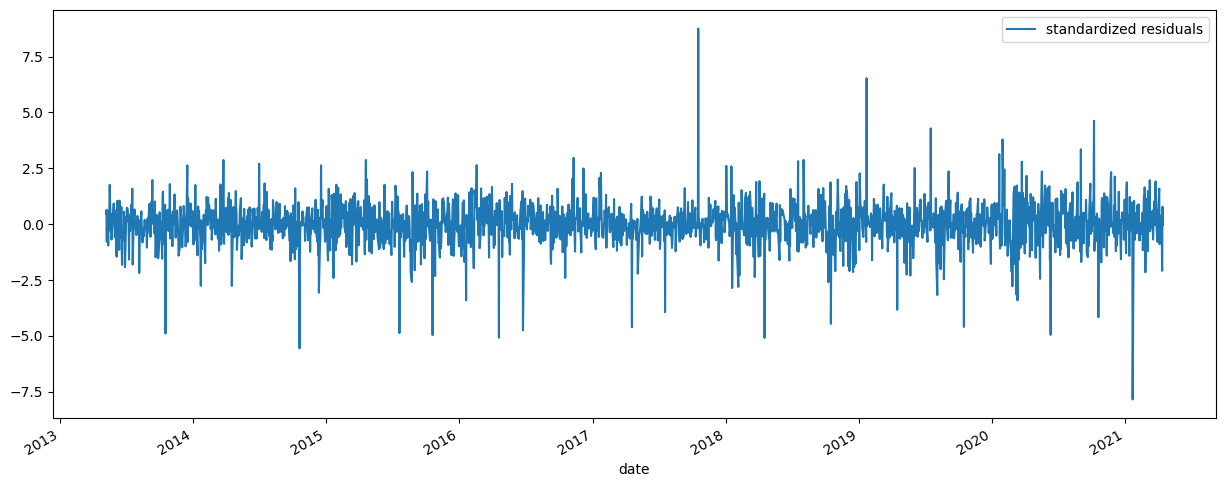

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax,label="standardized residuals")

# Add axis labels
plt.xlabel("date")


# Add legend
plt.legend();

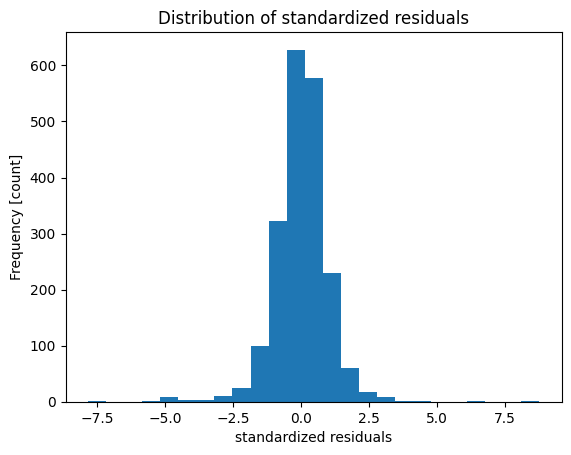

In [16]:
plt.hist(model.std_resid, bins=25)

# Add axis labels
plt.xlabel("standardized residuals")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of standardized residuals");

## Evaluate The model

In [18]:
one_day_forecast = model.forecast(horizon=1,reindex=False).variance
print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2021-04-15,1.773269


our model forecast shows the predicted variance, not the standard deviation / volatility. So we'll need to take the square root of the value. Second, the prediction is in the form of a DataFrame. It has a DatetimeIndex, and the date is the last day for which we have training data. The "h.1" column stands for "horizon 1", that is, our model's prediction for the following day

In [20]:
np.sqrt(one_day_forecast.iloc[0,0])

1.3316412852450017

## Walk Forward Validation

In [21]:
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_ibm) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_ibm.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train,p=1,q=1,rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1,reindex=False).variance.iloc[0,0]**0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_ibm.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2021-04-16    1.331641
2021-04-19    1.293914
2021-04-20    1.241522
2021-04-21    1.733318
2021-04-22    2.088826
dtype: float64

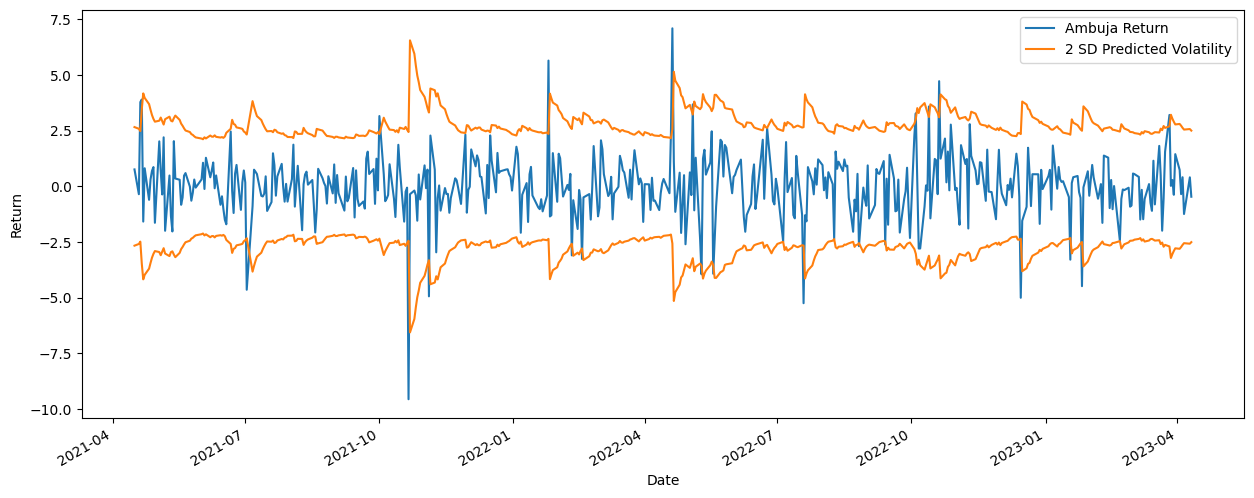

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_ibm.tail(test_size).plot(ax=ax, label="Ambuja Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

 Creating a clean_prediction function. It should take a variance prediction DataFrame as input and return a dictionary where each key is a date in ISO 8601 format and each value is the predicted volatility

In [23]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)


    # Create date range
    prediction_dates = pd.bdate_range(start = start , periods = prediction.shape[1])
    

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]


    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5


    # Combine `data` and `prediction_index` into Series
    prediction_formated = pd.Series(data , index= prediction_index)


    # Return Series as dictionary
    return prediction_formated.to_dict()

In [24]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)
prediction_formatted

{'2023-04-11T00:00:00': 1.2525217875241634,
 '2023-04-12T00:00:00': 1.2704732262349059,
 '2023-04-13T00:00:00': 1.2866522912672873,
 '2023-04-14T00:00:00': 1.3012554394670883,
 '2023-04-17T00:00:00': 1.3144530634411302,
 '2023-04-18T00:00:00': 1.3263938156898307,
 '2023-04-19T00:00:00': 1.3372080409885923,
 '2023-04-20T00:00:00': 1.347010536638134,
 '2023-04-21T00:00:00': 1.3559027982048353,
 '2023-04-24T00:00:00': 1.3639748658591195}